In [1]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
import time 

In [2]:
# load data 
mbd_data = pd.read_csv('./outputs/mbd_data.csv')
clusters = json.loads(open('./outputs/clusters_arima.json',"r").read())
cluster_keys = ["0","1","2","3","4","5","6","-1"]
mbd_data = mbd_data.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
mbd_data.median_hh_inc.ffill(inplace=True)
mbd_data.pct_it_workers.ffill(inplace=True)

sc = MinMaxScaler()
mbd_data.median_hh_inc = sc.fit_transform( mbd_data.median_hh_inc.values.reshape(-1,1) ).reshape(-1)

cfips = mbd_data.cfips.unique()

FileNotFoundError: [Errno 2] No such file or directory: './outputs/clusters_sarima.json'

In [3]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = np.mean(numerator / denominator)
    return smape_val

In [4]:
# Plot a county 

def plot_county(cfip):
#     cfip = clusters["-1"][0]
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))
    dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    # Plot the line
    ax.plot(dates, values)

    # Set the axis labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Microbusiness Density')
    ax.set_title(f'{location} ( CFIP {cfip} )  ')

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Show the plot
    plt.show()

In [5]:
# Adfuller Test : Check if for any county, microbusiness density is stationary 

# cfip = clusters["-1"][1]
stationary_count = 0 
stationary_counties = []
for cfip in clusters["-1"]: 
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    p_value = adfuller(values)[1]
    if p_value < 0.01 : 
        # reject null hypothesis . So time series is stationary 
        stationary_count += 1 
        stationary_counties.append(cfip)
stationary_count, len(clusters["-1"])

(13, 86)

In [6]:
# SARIMA model fit 
cfip = clusters["0"][0]
cfip

1099

In [7]:
data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

# Fit the seasonal ARIMA model
p, d, q , P, D, Q, s = [3, 0, 0, 0, 0, 2, 12]
model = sm.tsa.statespace.SARIMAX(data[:-2], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Make predictions
forecast = results.forecast(steps=2)

# Print the summary of the model
# print(results.summary())

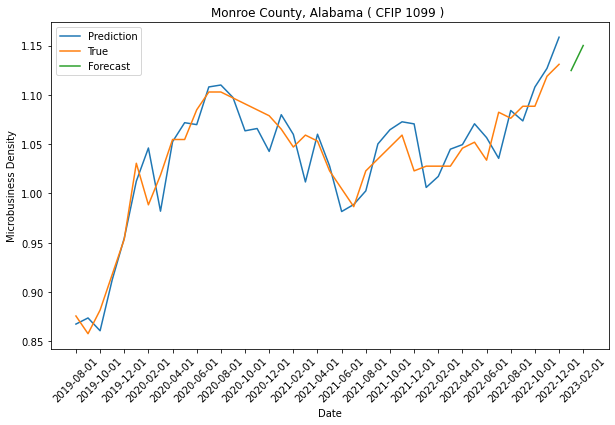

In [8]:
dates = pd.date_range(start='2019-08-01', end='2023-03-01', freq='MS')
dates = [date.strftime('%Y-%m-%d') for date in dates]

train_y_pred = results.predict()[1:]
train_y = data[1:-2]
test_y_pred = results.forecast(2)
test_y = data[-2:]   

y_pred = np.concatenate([train_y_pred, results.forecast(5)])
x = list(range(len(y_pred)))
location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
plt.figure(figsize=(10,6))
plt.plot(x[:len(data)],y_pred[:len(data)], label="Prediction")
plt.plot(x[:len(data)],data, label="True")
plt.plot(x[len(data):],y_pred[len(data):], label="Forecast")

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Microbusiness Density')
plt.title(f'{location} ( CFIP {cfip} ) ')
plt.xticks(x[::2], dates[::2], rotation=45)
plt.legend()
plt.show()

In [9]:
smape(results.predict()[1:],data[1:-2])

0.02357734065907622

In [10]:
smape(forecast, data[-2:])

0.006730790701915674

In [12]:
def do_task(p,d,q,P,D,Q,s,values):
    train, test = values[:-2], values[-2:]
    try: 
        model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit()
        
        train_smape = smape(results.predict()[1:],train[1:])
        test_smape = smape(results.forecast(2),test)
        return train_smape, test_smape
    except: 
        return np.inf, np.inf


def do_major_task(p,d,q,P,D,Q,s,data, train_least_smape, test_least_smape,best_params):
    train_smape, test_smape = do_task(p,d,q,P,D,Q,s,data)
    if test_smape < test_least_smape: 
        train_least_smape = train_smape
        test_least_smape = test_smape
        best_params = [p,d,q,P,D,Q,s]
    return train_least_smape, test_least_smape, best_params

def get_best_params(data):
    is_stationary = adfuller(data)[1] > 0.02
    if is_stationary: 
        total = 3*7*3*3*3
    else: 
        total = 3*7*3*2*3*3*2
#     pbar = tqdm(total=total)
    best_params = []
    train_least_smape = np.inf
    test_least_smape = np.inf
    cntr = 0 
    start = time.time()
    for s in range(0,13,6):
        for p in range(0,7): 
            for q in range(0,3): 
                if is_stationary: 
                    d = 0 
                    D = 0 
                    for P in range(0,3):
                        for Q in range(0,3):
                            train_least_smape, test_least_smape, best_params = do_major_task(p,d,q,P,D,Q,s,data, train_least_smape, test_least_smape,best_params)
#                             pbar.update(1)
                            cntr += 1
                            if cntr % 100 == 0 : 
                                end = time.time()
                                print(f"{cntr}/{total}",cfip,train_least_smape, test_least_smape, best_params, (end-start) ," seconds")
                else: 
                    for d in range(0,2):
                        for P in range(0,3):
                            for Q in range(0,3):
                                for D in range(0,2): 
                                    train_least_smape, test_least_smape, best_params = do_major_task(p,d,q,P,D,Q,s,data, train_least_smape, test_least_smape,best_params)
#                                     pbar.update(1)
                                    cntr += 1
                                    if cntr % 100 == 0 : 
                                        end = time.time()
                                        print(f"{cntr}/{total}",cfip,train_least_smape, test_least_smape, best_params, (end-start) ," seconds")
    return best_params,train_least_smape, test_least_smape


In [ ]:
cfip = clusters["0"][0]
data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
best_params,train_least_smape, test_least_smape = get_best_params(data)

100/567 1099 0.018289611190819875 0.031947488783744836 [3, 0, 0, 0, 0, 0, 0] 0.0  minutes passed
200/567 1099 0.02077227596521458 0.026868570578053065 [6, 0, 0, 0, 0, 0, 0] 0.0  minutes passed


In [ ]:
best_params,train_least_smape, test_least_smape

In [ ]:
cfip = clusters["0"][0]
data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
best_params,train_least_smape, test_least_smape = get_best_params(data)

In [ ]:
cfips_selected = clusters["0"][:2]
with multiprocessing.Pool(processes=2) as pool: 
    pool.map(get_best_params, cfips_selected)